# Console Analyses

Algumas estatísticas e analises com os dados encontrados.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sales_df = pd.read_csv('../data/console_weekly_sales.csv')
consoles_df = pd.read_csv('../data/console_stats.csv')

sales_df['week'] = pd.to_datetime(sales_df['week'])

merged_df = sales_df.merge(consoles_df, on='console')

## Análise Exploratória Inicial
### Estatísticas Descritivas


#### Métricas por console
- Vendas médias semanais
- Vendas totais acumuladas (soma de todas as semanas)
- Desvio padrão das vendas (para medir volatibilidade)
- Margem bruta

Vemos que 

In [42]:
# Calcular estatísticas básicas
console_metrics = sales_df.groupby('console')['sales'].agg(
    avg_weekly_sales=('mean'),
    total_sales=('sum'),
    sales_std=('std')
).reset_index()

# Adicionar dados de preço e custo
console_metrics = consoles_df[['console','type', '2025 price', '2025 cost']].merge(console_metrics, on='console')

# Calcular margem bruta
console_metrics['gross_margin'] = ((console_metrics['2025 price'] - console_metrics['2025 cost']) 
                                  / console_metrics['2025 price'])

# Formatando os resultados
console_metrics = console_metrics.round({
    'avg_weekly_sales': 2,
    'total_sales': 0,
    'sales_std': 2,
    'gross_margin': 3
}).rename(columns={
    '2025 price': 'preco_lancamento_ajustado',
    '2025 cost': 'custo_ajustado',
    'avg_weekly_sales': 'vendas_media_semanal',
    'total_sales': 'vendas_totais',
    'sales_std': 'volatilidade_vendas',
    'gross_margin': 'margem_bruta'
})

print("Métricas por Console:")
display(console_metrics)

Métricas por Console:


,console,type,preco_lancamento_ajustado,custo_ajustado,vendas_media_semanal,vendas_totais,volatilidade_vendas,margem_bruta
0,DS,portable,253.93,169.30,324253.00,154020176,330254.08,0.333
1,PSP,portable,409.35,311.12,130989.85,82523607,133501.14,0.240
2,Wii,static,396.56,250.64,213510.02,101630770,274957.99,0.368
3,X360,static,489.61,556.74,135653.78,85733192,177178.37,-0.137
4,PS3,static,791.57,1276.98,150172.46,87400374,161609.19,-0.613
5,3DS,portable,355.41,142.17,133934.31,75940755,172940.04,0.600
6,WiiU,static,416.47,250.72,50787.19,13560180,77356.12,0.398
7,PS4,static,547.74,523.03,201374.69,117200071,234239.43,0.045
8,XOne,static,685.02,646.58,121760.33,57957918,171904.59,0.056
9,PSV,portable,346.83,222.86,31272.12,13134292,38100.04,0.357


#### Métricas do mercado
- Vendas médias semanais
- Vendas totais acumuladas (soma de todas as semanas)
- Desvio padrão das vendas (para medir volatibilidade)
- Margem bruta

In [43]:
# Calcular métricas agregadas
total_revenue = (console_metrics['preco_lancamento_ajustado'] * console_metrics['vendas_totais']).sum()
total_cost = (console_metrics['custo_ajustado'] * console_metrics['vendas_totais']).sum()

market_metrics = {
    'vendas_media_semanal_mercado': sales_df['sales'].mean(),
    'vendas_totais_mercado': console_metrics['vendas_totais'].sum(),
    'volatilidade_mercado': sales_df.groupby('week')['sales'].sum().std(),
    'margem_bruta_mercado': (total_revenue - total_cost) / total_revenue
}

# Formatando para DataFrame
with pd.option_context('display.float_format', '{:.2f}'.format):
    market_metrics = pd.DataFrame(
        list(market_metrics.items()), 
        columns=['metric', 'value']
    )
    # Ajustar decimais específicos
    market_metrics['value'] = market_metrics.apply(
        lambda x: f"{x['value']:,.0f}" if 'totais' in x['metric'] else f"{x['value']:.3f}",
        axis=1
    )

print("\nMétricas do Mercado:")
display(market_metrics)


Métricas do Mercado:


,metric,value
0,vendas_media_semanal_mercado,169560.315
1,vendas_totais_mercado,"979,889,062"
2,volatilidade_mercado,461350.868
3,margem_bruta_mercado,0.049


#### Relação preço, custo e margem bruta

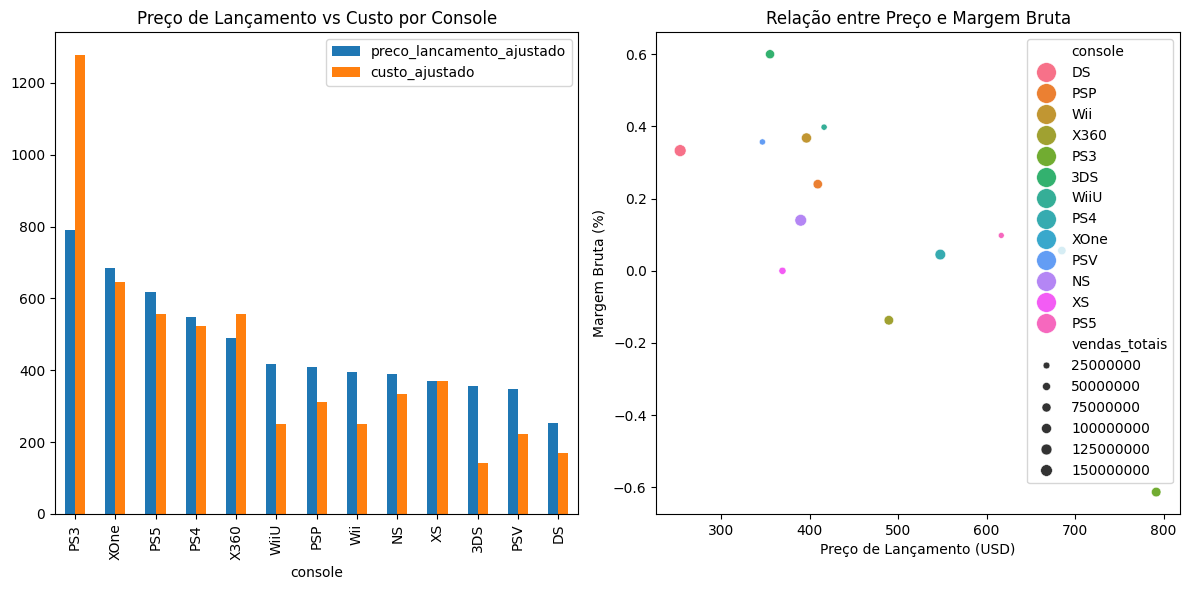

In [44]:
plt.figure(figsize=(12, 6))

# Gráfico de Barras Comparativas
ax = plt.subplot(1,2,1)
console_metrics.sort_values('preco_lancamento_ajustado', ascending=False).plot(
    x='console', 
    y=['preco_lancamento_ajustado', 'custo_ajustado'], 
    kind='bar', 
    ax=ax,
    title='Preço de Lançamento vs Custo por Console'
)

# Gráfico de Dispersão Margem Bruta
ax = plt.subplot(1,2,2)
sns.scatterplot(
    x='preco_lancamento_ajustado', 
    y='margem_bruta', 
    size='vendas_totais',
    hue='console',
    data=console_metrics,
    s=200,
    ax=ax
)
plt.title('Relação entre Preço e Margem Bruta')
plt.xlabel('Preço de Lançamento (USD)')
plt.ylabel('Margem Bruta (%)')

plt.tight_layout()
plt.show()

#### Curva de Demanda para Consoles (Usando Preço dos Consoles)
A elasticidade-preço da demanda mede o quanto a quantidade demandada responde a variações do preço. Como veremos a elasticidade é 0,08, desse modo dizemos que a demanda é inelástica no mercado de console de video games.

Elasticidade-Preço da Demanda: 0.080
Intervalo de Confiança 95%: (-1.376, 1.535)
Significância Estatística (p-value): 0.9060


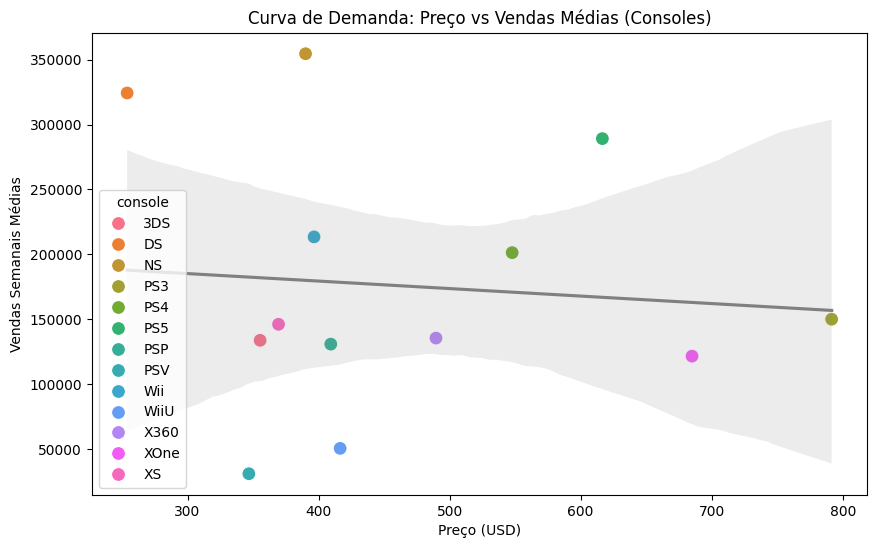

In [61]:
# Criar coluna de preço vigente
merged_df['current_price'] = merged_df['2025 price']

# Agrupar por preço e calcular vendas médias
demand_curve = merged_df.groupby(['console', 'current_price'])['sales'].mean().reset_index()

# Modelagem linear (elasticidade-preço)
import statsmodels.formula.api as smf

model = smf.ols('np.log(sales) ~ np.log(current_price)', data=demand_curve).fit()
elasticidade = model.params['np.log(current_price)']
intervalo_confianca = model.conf_int().loc['np.log(current_price)']
p_value = model.pvalues['np.log(current_price)']

# Resultados
print(f'Elasticidade-Preço da Demanda: {elasticidade:.3f}')
print(f'Intervalo de Confiança 95%: ({intervalo_confianca[0]:.3f}, {intervalo_confianca[1]:.3f})')
print(f'Significância Estatística (p-value): {p_value:.4f}')

# Gráfico da curva
plt.figure(figsize=(10,6))
sns.scatterplot(x='current_price', y='sales', hue='console', data=demand_curve, s=100)
sns.regplot(x='current_price', y='sales', data=demand_curve, scatter=False, color='grey')
plt.title('Curva de Demanda: Preço vs Vendas Médias (Consoles)')
plt.xlabel('Preço (USD)')
plt.ylabel('Vendas Semanais Médias')
plt.show()